### Objective: To download structures of antibodies from SAbDb. 

We want to compare the effects of using an experimentally solved structure versus a computational prediction with the AntibodyBuilder protien. 

We are getting the antibodies from SabDb. 


https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/pdb/6r8x/?raw=true


#### Load modules

In [14]:
import pandas as pd
from biopandas.pdb import PandasPdb
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from Bio.PDB.PDBIO import PDBIO, Select
from  pdbfixer import PDBFixer
from openmm.app import PDBFile
from pathlib import Path
import seaborn as sns
import numpy as np
import requests
from io import StringIO
from tqdm.notebook import tqdm 
import nglview as nv

import warnings
warnings.filterwarnings("ignore")

from developability.energy_minimization import EnergyMinimizer
from developability.utils import ls

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

#### Get tables for antibodies on ThSAbDb and one that I calculated descriptors for. 

In [2]:
desktop = Path().cwd().parent.parent.parent/'Desktop'

thab_df = pd.read_csv(desktop/'TSAbDb.csv')
thab_df = thab_df.rename({'Therapeutic': 'antibody'}, axis = 1)
thab_df['antibody'] =thab_df['antibody'].str.lower()

# clean up the entries. 
new_structure_map ={'100% SI Structure': 'structure100', '99% SI Structure':'structure99', '95-98% SI Structure': 'structure95'}
structure_columns = list(new_structure_map.values())
cols = ['antibody']+structure_columns

thab_df = thab_df.rename(new_structure_map, axis = 1)

# get only abs with structure. 
thabs_with_structure = (thab_df.replace('None;None', np.NaN)
                        .dropna(subset = structure_columns, how = 'all')
                        )

thabs_with_structure.head(10)[cols]

,antibody,structure100,structure99,structure95
1,abciximab,6v4p:CD,NaN,NaN
2,abelacimab,6r8x:CB,NaN,NaN
9,acimtamig,NaN,NaN,7seg:AB:HL;None
12,adalimumab,6cr1:HL/4nyl:AB:CD:EF:HL,3wd5:HL,NaN
15,adintrevimab,NaN,7u2d:HL,7u2e:HL
16,aducanumab,6cnr:HL/6co3:HL,NaN,NaN
17,afasevikumab,6ppg:HL:BA,NaN,NaN
19,alemtuzumab,1bey:HL/1ce1:HL,NaN,NaN
22,alomfilimab,7joo:HL,NaN,NaN
25,amatuximab,7ued:HL,4f33:BA:DC:FE:HG/4f3f:BA,NaN


#### Load info on antibodies that I computed on. 

In [3]:
renumbered_abs = desktop/'renumbered_abs'
desc_df = (pd.read_csv(renumbered_abs/'antibody_descriptor_results.csv').
           sort_values(['antibody'])
           )
desc_df.head()

,antibody,Heparin,FcRn,HCDR1_APBS_pos,LCDR1_APBS_pos,HCDR2_APBS_pos,LCDR2_APBS_pos,HCDR3_APBS_pos,LCDR3_APBS_pos,HFR1_APBS_pos,LFR1_APBS_pos,HFR2_APBS_pos,LFR2_APBS_pos,HFR3_APBS_pos,LFR3_APBS_pos,HFR4_APBS_pos,LFR4_APBS_pos,HFR5_APBS_pos,LFR5_APBS_pos,HCDR1_APBS_neg,LCDR1_APBS_neg,HCDR2_APBS_neg,LCDR2_APBS_neg,HCDR3_APBS_neg,LCDR3_APBS_neg,HFR1_APBS_neg,LFR1_APBS_neg,HFR2_APBS_neg,LFR2_APBS_neg,HFR3_APBS_neg,LFR3_APBS_neg,HFR4_APBS_neg,LFR4_APBS_neg,HFR5_APBS_neg,LFR5_APBS_neg,HCDR1_APBS_net,LCDR1_APBS_net,HCDR2_APBS_net,LCDR2_APBS_net,HCDR3_APBS_net,LCDR3_APBS_net,HFR1_APBS_net,LFR1_APBS_net,HFR2_APBS_net,LFR2_APBS_net,HFR3_APBS_net,LFR3_APBS_net,HFR4_APBS_net,LFR4_APBS_net,HFR5_APBS_net,LFR5_APBS_net,CDR_APBS_pos,CDR_APBS_neg,CDR_APBS_net
18,abituzumab,0.60,0.32,0.0,371.693814,641.739742,0.0,0.000000,0.0,357.548661,797.575970,0.00000,0.000000,39.594129,481.670328,2.207375,636.828912,0.0,0.0,0.000000,0.000000,0.000000,-207.138832,-206.200310,0.0,-109.123653,-197.107871,0.0,0.0,0.000000,-522.526463,0.0,0.000000,0.0,0.0,0.000000,371.693814,641.739742,-207.138832,-206.200310,0.0,248.425008,600.468099,0.00000,0.000000,39.594129,-40.856135,2.207375,636.828912,0.0,0.0,3328.858931,-1242.097129,2086.761801
60,abrilumab,0.51,-0.17,0.0,0.000000,0.000000,0.0,0.000000,0.0,61.045545,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-1671.831677,-483.307386,0.000000,-1129.535798,0.0,-384.612316,-1029.512362,0.0,0.0,-171.852313,-2850.521020,0.0,-142.163487,0.0,0.0,0.000000,-1671.831677,-483.307386,0.000000,-1129.535798,0.0,-323.566771,-1029.512362,0.00000,0.000000,-171.852313,-2850.521020,0.000000,-142.163487,0.0,0.0,61.045545,-7863.336359,-7802.290814
0,adalimumab,0.79,1.04,0.0,74.602083,0.000000,0.0,72.789843,0.0,153.383089,20.187507,1702.70668,0.000000,0.000000,59.306815,0.000000,0.000000,0.0,0.0,-301.739172,0.000000,0.000000,-20.559124,-2.407174,0.0,-80.875905,-260.498418,0.0,0.0,0.000000,-808.085724,0.0,0.000000,0.0,0.0,-301.739172,74.602083,0.000000,-20.559124,70.382669,0.0,72.507184,-240.310912,1702.70668,0.000000,0.000000,-748.778909,0.000000,0.000000,0.0,0.0,2082.976016,-1474.165517,608.810499
65,alemtuzumab,0.70,0.09,0.0,0.000000,2457.885799,0.0,0.000000,0.0,19.395515,1812.618798,0.00000,354.410952,419.303576,2398.477081,0.000000,0.000000,0.0,0.0,-208.558432,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,-208.558432,0.000000,2457.885799,0.000000,0.000000,0.0,19.395515,1812.618798,0.00000,354.410952,419.303576,2398.477081,0.000000,0.000000,0.0,0.0,7462.091722,-208.558432,7253.533290
63,alirocumab,0.56,0.36,0.0,62.395065,183.814279,0.0,0.000000,0.0,12.876376,99.215793,0.00000,0.000000,578.623439,976.349954,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-181.625254,0.000000,0.000000,0.0,-646.620776,-326.959686,0.0,0.0,0.000000,-25.525698,0.0,0.000000,0.0,0.0,0.000000,62.395065,2.189025,0.000000,0.000000,0.0,-633.744399,-227.743893,0.00000,0.000000,578.623439,950.824255,0.000000,0.000000,0.0,0.0,1913.274907,-1180.731414,732.543492


#### Parse into long format. 
Below I parse the data above. 

In [4]:
therapeutic_abs_long =[]
struct_cols = ['structure100', 'structure99', 'structure95']

for _,row in thabs_with_structure.iterrows():
    antibody = row.antibody
    for col in struct_cols:
          try: 
              if row[col]: 
                  for pdb_entry in row[col].split('/'):
                       pdb_code, chains = pdb_entry.split(':') 
                       therapeutic_abs_long.append((antibody, pdb_code.replace('None;',''), chains, col.replace('structure', '') ))
          except:
               pass
        
therapeutic_abs_long=pd.DataFrame(therapeutic_abs_long, columns= ['antibody', 'pdb_code', 'Fab', '%'])
therapeutic_abs_long['%'] = therapeutic_abs_long['%'].astype(int)
therapeutic_abs_long = therapeutic_abs_long.sort_values(['antibody','%'], ascending = [True, False] )
therapeutic_abs_long.head()


,antibody,pdb_code,Fab,%
0,abciximab,6v4p,CD,100
1,abelacimab,6r8x,CB,100
2,adalimumab,6cr1,HL,100
3,adalimumab,3wd5,HL,99
4,adintrevimab,7u2d,HL,99


#### Functions 

In [25]:
def download_therapeutic_ab_pdb(code, name, output_dir=None):

    if not output_dir: 
        output_dir = Path().cwd()

    url = f'https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/pdb/{code}/?raw=true'
    
    file = Path(output_dir)/f'{code}_{name}.pdb'
    file.write_text(requests.get(url).text)

def download_pdb(pdb_id, protein_name='',output_path=None, pdb=None, atoms_only=False): 
    """Uses BioPandas to download pdb"""
    if not pdb: 
        pdb= PandasPdb()
    p = pdb.fetch_pdb(pdb_id)

    if not output_path: 
        output_path = Path().cwd()
    
    if atoms_only:
        p.to_pdb(output_path/f'{protein_name}_{pdb_id}.pdb', records =['ATOM'])
    else:
        p.to_pdb(output_path/f'{protein_name}_{pdb_id}.pdb')
    

def parse_structure_string(string): 
    
    pdbs = string.split('/')
    for pdb in pdbs: 
        yield(pdb.split(':')[0])

def get_summary(pdb_code, name):
    """gets summary from ThSAbDb for a pdb_code"""
    url = f'https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/summary/{pdb_code}/'
    text=requests.get(url).text
    summary = pd.read_csv(StringIO(text), sep='\t')
    summary.insert(0, 'antibody', name)
    return summary


def show_struct(pdb_file, size = 500, gui = False): 
    print(pdb_file.name)
    view = nv.show_structure_file(str(pdb_file))
    view._remote_call('setSize', target='Widget', args=['',f'{size}px'])
    view.render_image(factor = 2)
    view.display(gui)
    return view
    

class ChainSelect(Select): 
    def __init__(self, chain_ids):
        """Select for getting specific chains

        Args:
            chain_ids (list[str]): list of chain ids
        """
        self.chain_ids = chain_ids

    def accept_chain(self, chain): 
        if chain.get_id() in self.chain_ids: 
            return True
        else: 
            return False


def save_pdb_with_select_chains(input_pdb, chains, output_path=None): 
    """Saves pdbs as new file with select chains only
    Args:
        input_pdb (Path|str): Path to the input_pdb
        chains (list[str]): list of names for chain
        output_path (Path|str, optional): Output path. Defaults to None.
    Returns:
        None
    """
    input_pdb = Path(input_pdb)
    name = input_pdb.name.split('.')[0]
    output_name = f'{name}_{"".join(chains)}.pdb'

    if not output_path: 
        output_path = input_pdb.parent
        
    parser = PDBParser()
    struct= parser.get_structure(name, str(input_pdb))
    
    io = PDBIO()
    io.set_structure(struct)
    io.save(str(output_path/output_name),ChainSelect(chains))


def remove_chains(fixer, chains_to_keep): 
    """Uses fixer.remove_chains to remove chains not present in chain_to_keep. Keeps the first occurence of each chain. 

    Args:
        fixer (pdbfixer.pdbfixer.PDBFixer): fixer object for fixing pdbs. 
        chains_to_keep (list[str]): list of chain ids to keep, all others removed
    Returns: 
        None
    """
    seen = set()
    indices_to_remove = []
    for i, chain in enumerate(fixer.topology.chains()):
        if chain.id not in seen and chain.id in chains_to_keep: 
            seen.add(chain.id)
        else:
            indices_to_remove.append(i) 

    fixer.removeChains(indices_to_remove)   
    return fixer


def fix_antibody(antibody_file, chains_to_keep=[], output_path=None, keep_ids=False, fix_internal_residues_only=True): 
    """Uses PDB fixer to fix antibody
    Args: 
        antibody_file(str|Path): file path
        chains_to_keep(list[str]): list of Fab chains to keep
    Returns: 
        None
    """
    fixer = PDBFixer(str(antibody_file))

    if chains_to_keep: 
        remove_chains(fixer, chains_to_keep)
    fixer.findMissingResidues()

    if fix_internal_residues_only: 
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        keys_to_remove = []
        for key in keys:
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                keys_to_remove.append(key)

        for key in keys_to_remove: 
            del fixer.missingResidues[key]

    fixer.findNonstandardResidues()
    fixer.replaceNonstandardResidues()
    fixer.removeHeterogens(False)
    fixer.findMissingAtoms()
    fixer.addMissingAtoms()

    # save
    if not output_path: 
        output_path = antibody_file.parent

    output = str(output_path /antibody_file.name)
    PDBFile.writeFile(fixer.topology, fixer.positions, open(output, 'w'), keepIds = keep_ids)
    return fixer

#### Download the antibodies

In [6]:
output_path = desktop/'solved_therapeutic_abs'
if not output_path.exists(): 
    output_path.mkdir()
    
pdb = PandasPdb()
proteins = []
pdb_ids = []

failed_sequences = []
for _,row in thabs_with_structure.iterrows():
    protein = row.antibody
    for string in [row.structure100, row.structure99, row.structure95 ]:
        if isinstance(string, str):
            for pdb_id in parse_structure_string(string):
                pdb_id = pdb_id.replace('None;','')
                fname = output_path/f'{protein}_{pdb_id}.pdb'
                if not fname.exists():
                    try:
                        download_pdb(pdb_id, protein, output_path )
                        proteins.append(protein)
                        pdb_ids.append(pdb_id)
                    except:
                        failed_sequences.append(f'{protein}_{pdb_id}')

HTTP Error 404
HTTP Error 404
HTTP Error 404
HTTP Error 404


#### Download summaries. 

In [7]:
summary_file = desktop/'ab_summaries.csv'
if not summary_file.exists(): 

    summaries = []
    for _,row in thabs_with_structure.iterrows():
        protein = row.antibody
        for string in [row.structure100, row.structure99, row.structure95_98 ]:
            if isinstance(string, str):
                for pdb_id in parse_structure_string(string):
                    pdb_id = pdb_id.replace('None;','')
                    try:
                            summaries.append(get_summary(pdb_id, protein))
                    except:
                        pass

    sum_df = pd.concat(summaries)
    sum_df = sum_df.rename({'ab': 'antibody'}, axis=1)
    sum_df.to_csv(desktop/'ab_summaries.csv', index = False)
else:
    sum_df = pd.read_csv(summary_file) 
                        

In [8]:
# select xray-crystalls only
print(f'Total number pdbs is {len(sum_df)}')
sum_df = sum_df.query('method=="X-RAY DIFFRACTION"')
# dedupe based on pdb
sum_df = sum_df.drop_duplicates(subset = ['pdb'])
print(f'Number of unique pdbs for x-ray diffraction is {len(sum_df)}')


Total number pdbs is 2146
Number of unique pdbs for x-ray diffraction is 462


#### Plot the resolution and r factors

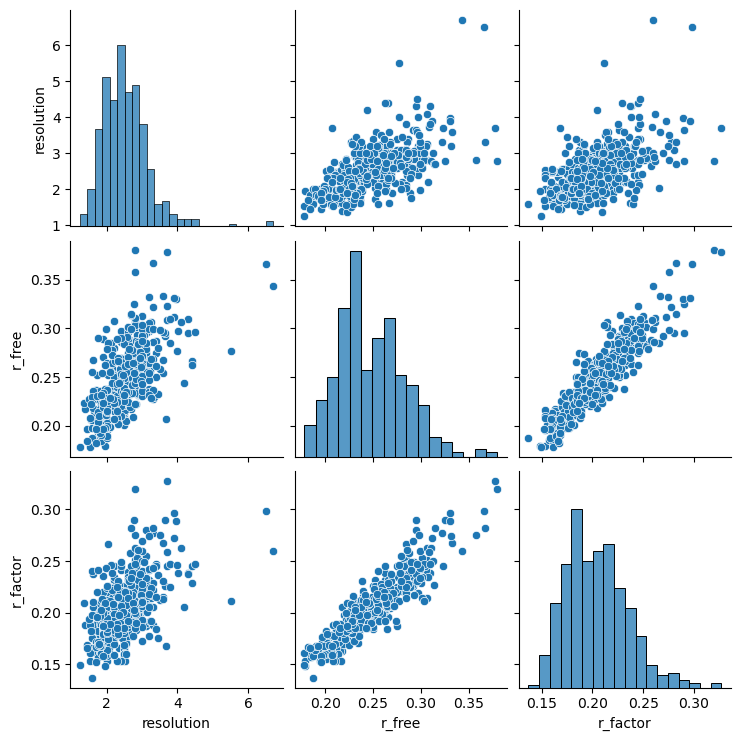

In [9]:
sum_df_subset = (sum_df[['resolution','r_free', 'r_factor']]
                 .replace('unknown', np.NAN)
                 .dropna()
                 .astype(float)
                 .copy())
sns.pairplot(sum_df_subset);

#### Order by antibody and resolution and then drop duplicate antibodies. 

In [10]:
sum_df = (sum_df.sort_values(['antibody', 'resolution'])
          .drop_duplicates(subset ='antibody')
          )
len(sum_df)

print(f'Number of pdbs of unique antibodies for x-ray diffraction is {len(sum_df)}.')

Number of pdbs of unique antibodies for x-ray diffraction is 204.


#### Save PDBs with only a single  Heavy and light chain for the 204 antibodies

In [11]:
fab_path = desktop/'HeavyLightChainAbPdbs'
if not fab_path.exists(): 
    fab_path.mkdir()

failed_abs = []
successful_abs = []

for _,row in tqdm(sum_df.iterrows(), total =len(sum_df)): 
    filename = f'{row.antibody}_{row.pdb}.pdb'
    input_pdb = output_path/filename
    if (input_pdb).exists(): 
        try: 
            chains_to_keep = [row['Hchain'],	row['Lchain']]
            print(row.antibody,chains_to_keep)
            fix_antibody(input_pdb,chains_to_keep,  output_path=fab_path, keep_ids=True)
            successful_abs.append(row.antibody)
        except: 
            failed_abs.append(row.antibody)

  0%|          | 0/204 [00:00<?, ?it/s]

abelacimab ['C', 'B']
acimtamig ['H', 'L']
adalimumab ['H', 'L']
adintrevimab ['H', 'L']
aducanumab ['H', 'L']
afasevikumab ['B', 'A']
alemtuzumab ['H', 'L']
alomfilimab ['H', 'L']
amatuximab ['B', 'A']
amivantamab ['H', 'L']
amubarvimab ['H', 'L']
anbenitamab ['B', 'A']
andecaliximab ['H', 'L']
anetumab ['C', 'c']
anifrolumab ['H', 'L']
ansuvimab ['H', 'L']
anzurstobart ['H', 'L']
apitegromab ['H', 'L']
arcitumomab ['H', 'L']
atezolizumab ['H', 'L']
atisnolerbart ['H', 'L']
avelumab ['H', 'L']
bafisontamab ['J', 'K']
bamlanivimab ['A', 'B']
bapineuzumab ['H', 'L']
barecetamab ['B', 'C']
basiliximab ['H', 'L']
bebtelovimab ['A', 'B']
belimumab ['H', 'L']
beludavimab ['A', 'B']
bentracimab ['H', 'L']
benufutamab ['A', 'B']
berlimatoxumab ['H', 'L']
bevacizumab ['B', 'A']
bezlotoxumab ['H', 'L']
bifikafusp ['A', 'a']
bimagrumab ['H', 'L']
bococizumab ['H', 'L']
boserolimab ['C', 'B']
bremzalerbart ['H', 'L']
briakinumab ['B', 'A']
burosumab ['B', 'A']
camrelizumab ['B', 'b']
canakinumab 

### Look at some of these strucutres and compare to sequence. 

In [12]:
thabs_df = thabs_with_structure[['antibody','Format', 'Heavy Sequence', 'Light Sequence']].merge(sum_df,on='antibody')
thabs_df.head(1)

,antibody,Format,Heavy Sequence,Light Sequence,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,compound,organism,heavy_species,light_species,antigen_species,authors,resolution,method,r_free,r_factor,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid,<!doctype html>
0,abelacimab,Whole mAb,QVQLLESGGGLVQPGGSLRLSCAASGFTFSTAAMSWVRQAPGKGLE...,QSVLTQPPSASGTPGQRVTISCSGSSSNIGSNDVSWYQQLPGTAPK...,6r8x,C,B,0.0,A,protein,NaN,coagulation factor xi,BLOOD CLOTTING,04/02/19,COAGULATION FACTOR XI CATALYTIC DOMAIN IN COMP...,HOMO SAPIENS; UNIDENTIFIED,unidentified,unidentified,homo sapiens,"Schiering, N., Koch, A.",2.04,X-RAY DIFFRACTION,0.282,0.22,False,True,IGHV3,IGLV1,Lambda,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
fixed_files = [f for f in ls(fab_path) if f.suffix=='.pdb']
fixed_files.sort()

f = fixed_files[0]
show_struct(f)

abelacimab_6r8x.pdb


NGLWidget()